In [2]:
__author__ = 'Phil Baltazar'
__email__  = 'phillusnow@gmail.com'
__website__= 'www.github.com/pbswe'

# 1. Define 
The Problem.

#### A small dataset of the top Spotify songs from the last decade, measured by popularity. 

We would like to know if there is any relation between these top songs and their genre, or artist, or length or any other feature present in this dataset that show us correlation with popularity, or what traits (if any) do popular songs have to each other. 

###### Note: This dataset was downloaded from Kaggle at
https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV,RepeatedStratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
import inspect
import xgboost
import pickle

%matplotlib inline

# 2. Discover
The data.

#### -- Loading the data --

In [2]:
df = pd.read_csv('../Spotify/top10s.csv')
df50 = pd.read_csv('../Spotify/top50.csv')

In [3]:
# Visualize the data
df.head()

,top10s,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,NaN,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
1,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
2,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
3,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
4,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79


#### -- Cleaning the data --

In [4]:
df.columns

Index(['top10s', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14'],
      dtype='object')

In [5]:
# Adjusting column/header titles
header = ['Index', 'Title', 'Artist', 'Genre', 'Year', 'BPM',
       'Energy', 'Danceability', 'Loudness dB', 'Liveness', 'Valence',
       'Length', 'Acousticness', 'Speechiness', 'Popularity']
df.columns = header

In [6]:
df = df.drop([0], axis=0)

In [7]:
df.head()

,Index,Title,Artist,Genre,Year,BPM,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
1,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
2,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
3,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
4,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
5,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


In [8]:
# Adjusting column/header titles for df50 and types.
header50 = ['Index', 'Title', 'Artist', 'Genre', 'Year', 'BPM', 'Energy', 'Danceability', 
            'Loudness dB', 'Liveness', 'Valence', 'Length', 'Acousticness', 
            'Speechiness', 'Popularity']
df50.columns = header50
df50[['Title', 'Artist', 'Genre']] = df50[['Title', 'Artist', 'Genre']].astype('category')
df50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Index         50 non-null     int64   
 1   Title         50 non-null     category
 2   Artist        50 non-null     category
 3   Genre         50 non-null     category
 4   Year          50 non-null     int64   
 5   BPM           50 non-null     int64   
 6   Energy        50 non-null     int64   
 7   Danceability  50 non-null     int64   
 8   Loudness dB   50 non-null     int64   
 9   Liveness      50 non-null     int64   
 10  Valence       50 non-null     int64   
 11  Length        50 non-null     int64   
 12  Acousticness  50 non-null     int64   
 13  Speechiness   50 non-null     int64   
 14  Popularity    50 non-null     int64   
dtypes: category(3), int64(12)
memory usage: 10.2 KB


In [9]:
# Checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 1 to 603
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Index         603 non-null    object
 1   Title         603 non-null    object
 2   Artist        603 non-null    object
 3   Genre         603 non-null    object
 4   Year          603 non-null    object
 5   BPM           603 non-null    object
 6   Energy        603 non-null    object
 7   Danceability  603 non-null    object
 8   Loudness dB   603 non-null    object
 9   Liveness      603 non-null    object
 10  Valence       603 non-null    object
 11  Length        603 non-null    object
 12  Acousticness  603 non-null    object
 13  Speechiness   603 non-null    object
 14  Popularity    603 non-null    object
dtypes: object(15)
memory usage: 75.4+ KB


In [10]:
# Fixing data types. Not all numerical data should be handled as numbers. 
# For example, popularity is shown as numbers but should still be categorical. 

# Calling columns again after fixed:

df.columns

Index(['Index', 'Title', 'Artist', 'Genre', 'Year', 'BPM', 'Energy',
       'Danceability', 'Loudness dB', 'Liveness', 'Valence', 'Length',
       'Acousticness', 'Speechiness', 'Popularity'],
      dtype='object')

In [11]:
categoricCols = ['Index', 'Title', 'Artist', 'Genre', 'Popularity']
numericCols = ['Year', 'BPM', 'Energy', 'Danceability', 'Loudness dB',
                 'Liveness', 'Valence', 'Length', 'Acousticness', 'Speechiness']

df[categoricCols] = df[categoricCols].astype('category')
df[numericCols] = df[numericCols].astype('int')

In [12]:
# Checking dtypes again to see if they were changed correctly.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 1 to 603
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Index         603 non-null    category
 1   Title         603 non-null    category
 2   Artist        603 non-null    category
 3   Genre         603 non-null    category
 4   Year          603 non-null    int64   
 5   BPM           603 non-null    int64   
 6   Energy        603 non-null    int64   
 7   Danceability  603 non-null    int64   
 8   Loudness dB   603 non-null    int64   
 9   Liveness      603 non-null    int64   
 10  Valence       603 non-null    int64   
 11  Length        603 non-null    int64   
 12  Acousticness  603 non-null    int64   
 13  Speechiness   603 non-null    int64   
 14  Popularity    603 non-null    category
dtypes: category(5), int64(10)
memory usage: 118.2 KB


In [13]:
# Checking for duplicates (zero is good, zero means there aren't any duplicates).
df.duplicated().sum()

0

In [14]:
df.describe()

,Year,BPM,Energy,Danceability,Loudness dB,Liveness,Valence,Length,Acousticness,Speechiness
count,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000
mean,2014.592040,118.545605,70.504146,64.379768,-5.578773,17.774461,52.225539,224.674959,14.326700,8.358209
std,2.607057,24.795358,16.310664,13.378718,2.798020,13.102543,22.513020,34.130059,20.766165,7.483162
min,2010.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,134.000000,0.000000,0.000000
25%,2013.000000,100.000000,61.000000,57.000000,-6.000000,9.000000,35.000000,202.000000,2.000000,4.000000
50%,2015.000000,120.000000,74.000000,66.000000,-5.000000,12.000000,52.000000,221.000000,6.000000,5.000000
75%,2017.000000,129.000000,82.000000,73.000000,-4.000000,24.000000,69.000000,239.500000,17.000000,9.000000
max,2019.000000,206.000000,98.000000,97.000000,-2.000000,74.000000,98.000000,424.000000,99.000000,48.000000


#### -- Exploring the data (EDA) --

In [15]:
df['Popularity'].value_counts()

72    33
78    27
73    26
76    24
65    23
      ..
96     1
48     1
95     1
93     1
99     1
Name: Popularity, Length: 71, dtype: int64

In [16]:
# Exploring upper and lower quartiles (IQR)
# Will require Popularity dtype change to 'int'.

df['Popularity'] = df['Popularity'].astype('int')

dataset = df.Popularity.describe()
print(dataset)
IQR = dataset['75%']-dataset['25%']
upperlimit = dataset['75%'] + (1.5*IQR)
lowerlimit = dataset['25%'] - (1.5*IQR)
print("The upper outlier limit is", upperlimit)
print("The lower outlier limit is", lowerlimit)

count    603.000000
mean      66.520730
std       14.517746
min        0.000000
25%       60.000000
50%       69.000000
75%       76.000000
max       99.000000
Name: Popularity, dtype: float64
The upper outlier limit is 100.0
The lower outlier limit is 36.0


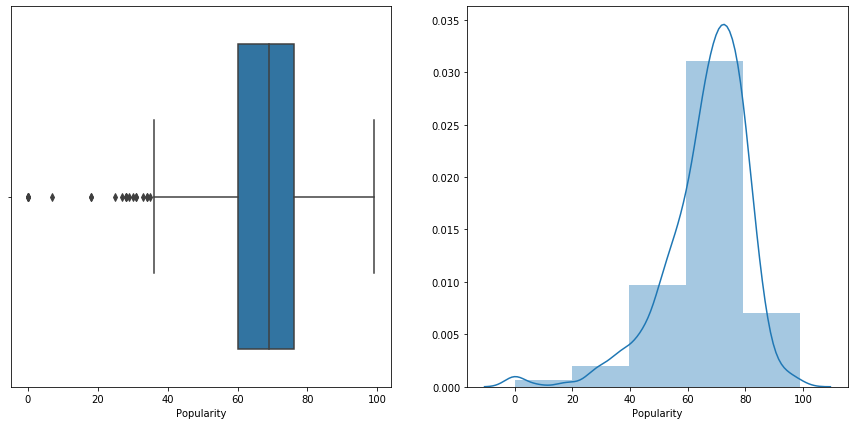

In [17]:
# Explore the target variable: popularity.
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df.Popularity)
plt.subplot(1, 2, 2)
sns.distplot(df.Popularity, bins=5)
plt.show()

In [18]:
# Creating a function to plot the feature variables.
# This will help visualize possible correlation with popularity. 
def plotFeats(df, var): 
    '''
    creates a plot for each feature
    plot1(left), sample distribution
    plot2(right), popularity dependance/relationship
    '''
    plt.figure(figsize = (30, 15))
    plt.subplot(1, 2, 1)
    if df[var].dtype == 'int':
        plt.hist(df[var], bins=5)
    else:
        #change the object datatype of each variable to category type and \n
        #order their level by the mean popularity
        mean = df.groupby(var)['Popularity'].mean()
        df[var] = df[var].astype('category')
        level = mean.sort_values().index.tolist()
        df[var].cat.reorder_categories(level, inplace=True)
        df[var].value_counts().plot(kind='bar')   
    plt.xticks(rotation=45, size=8)
    plt.xlabel(var)
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)

    if df[var].dtype == 'int': 
       #Plot the mean popularity for each category and shade the line \n 
       #between the (mean - std, mean + std)
        mean = df.groupby(var)['Popularity'].mean()
        std = df.groupby(var)['Popularity'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values,alpha = 0.1)
    else:
        sns.boxplot(x= var, y='Popularity', data= df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Popularity')
    plt.show()
#    plt.savefig("image.png",bbox_inches='tight',dpi=500)

In [19]:
# Plotting every feature against "Popularity", using the function above.
# Starting with categorical values, followed by the numerical values after.

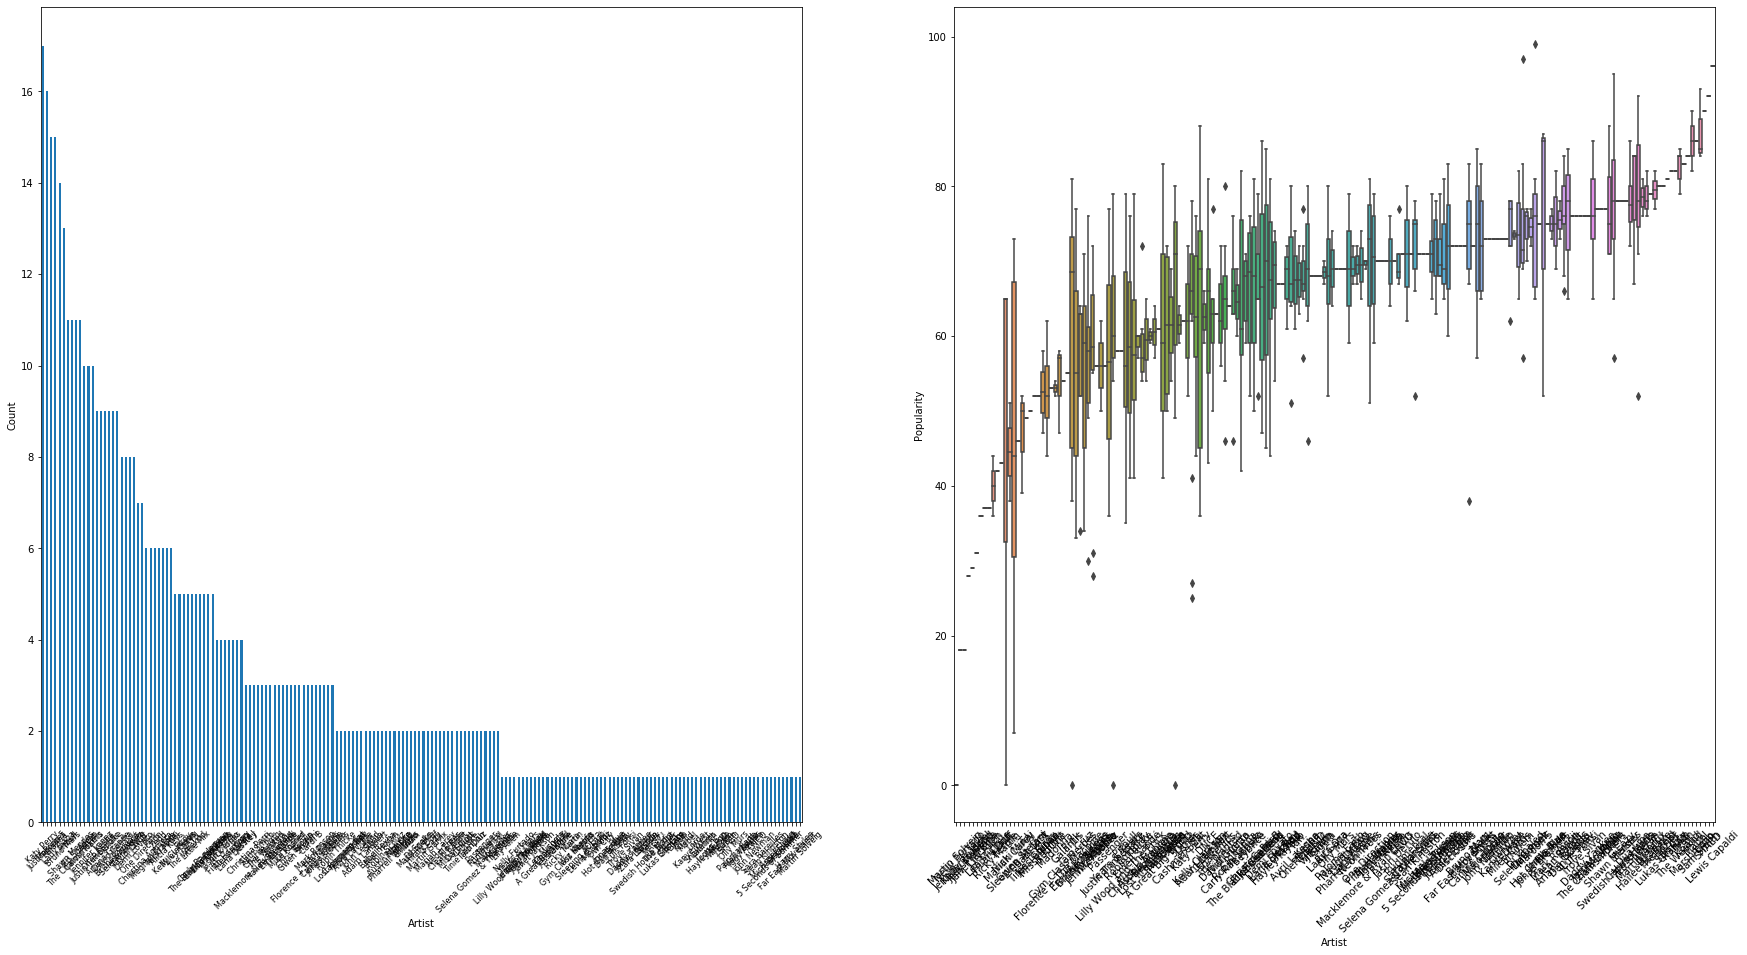

In [20]:
plotFeats(df, 'Artist')

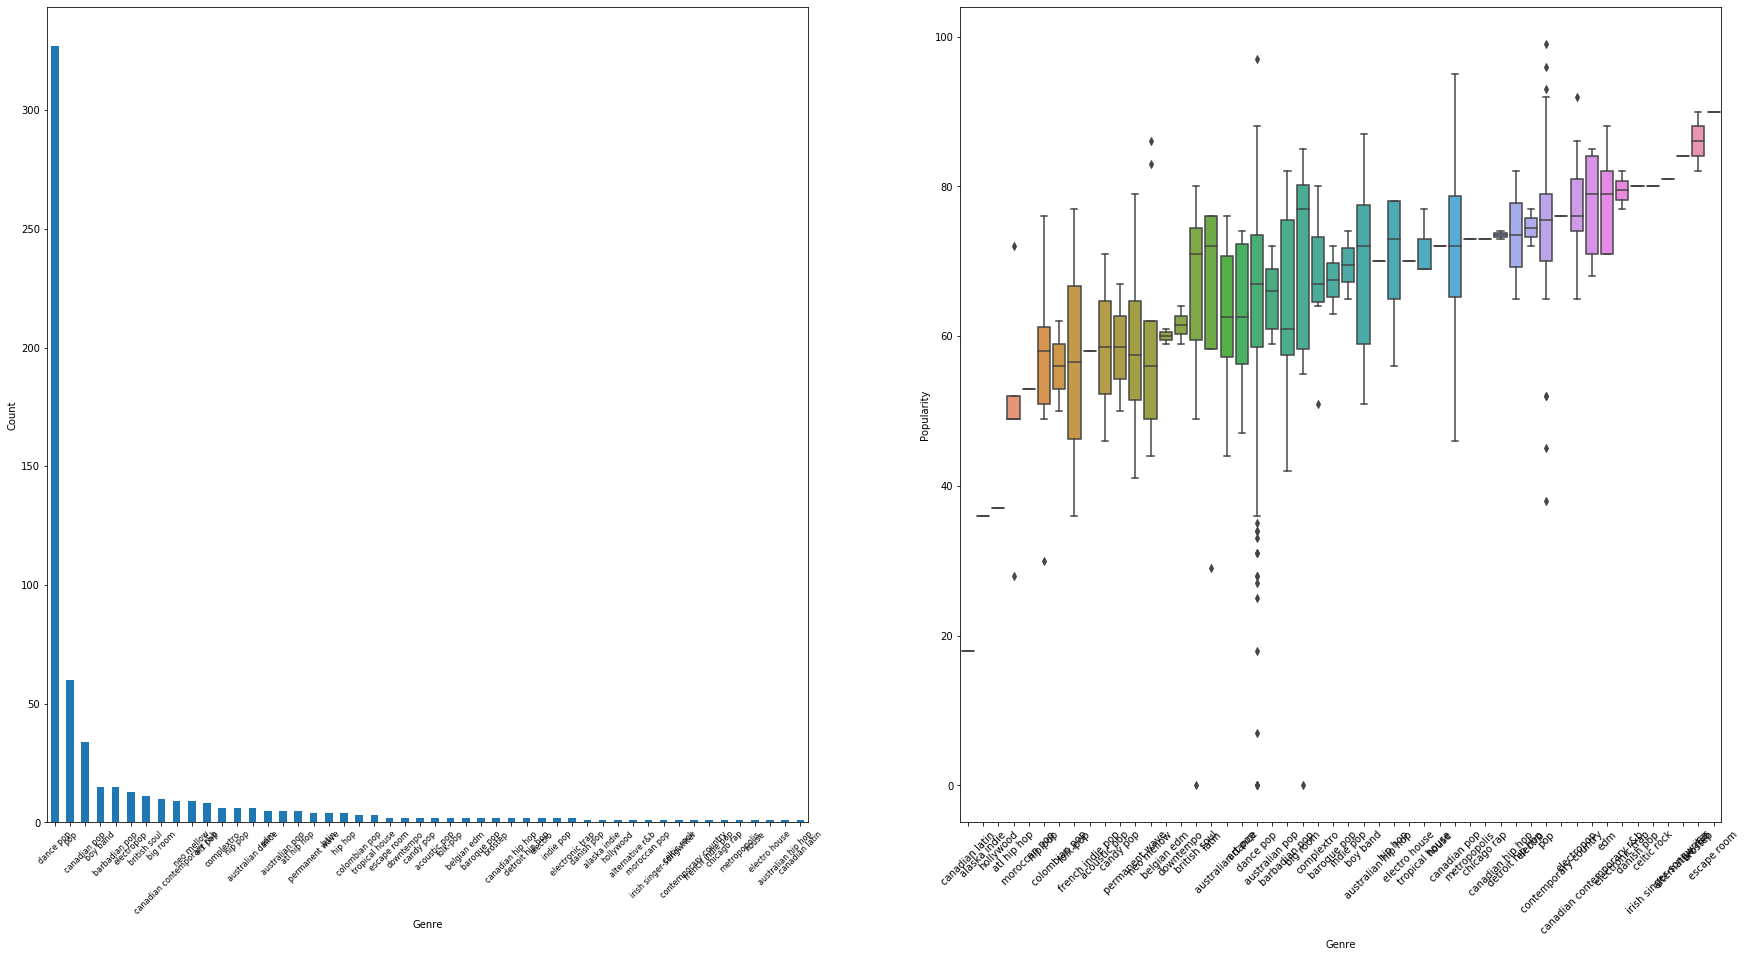

In [21]:
plotFeats(df, 'Genre')

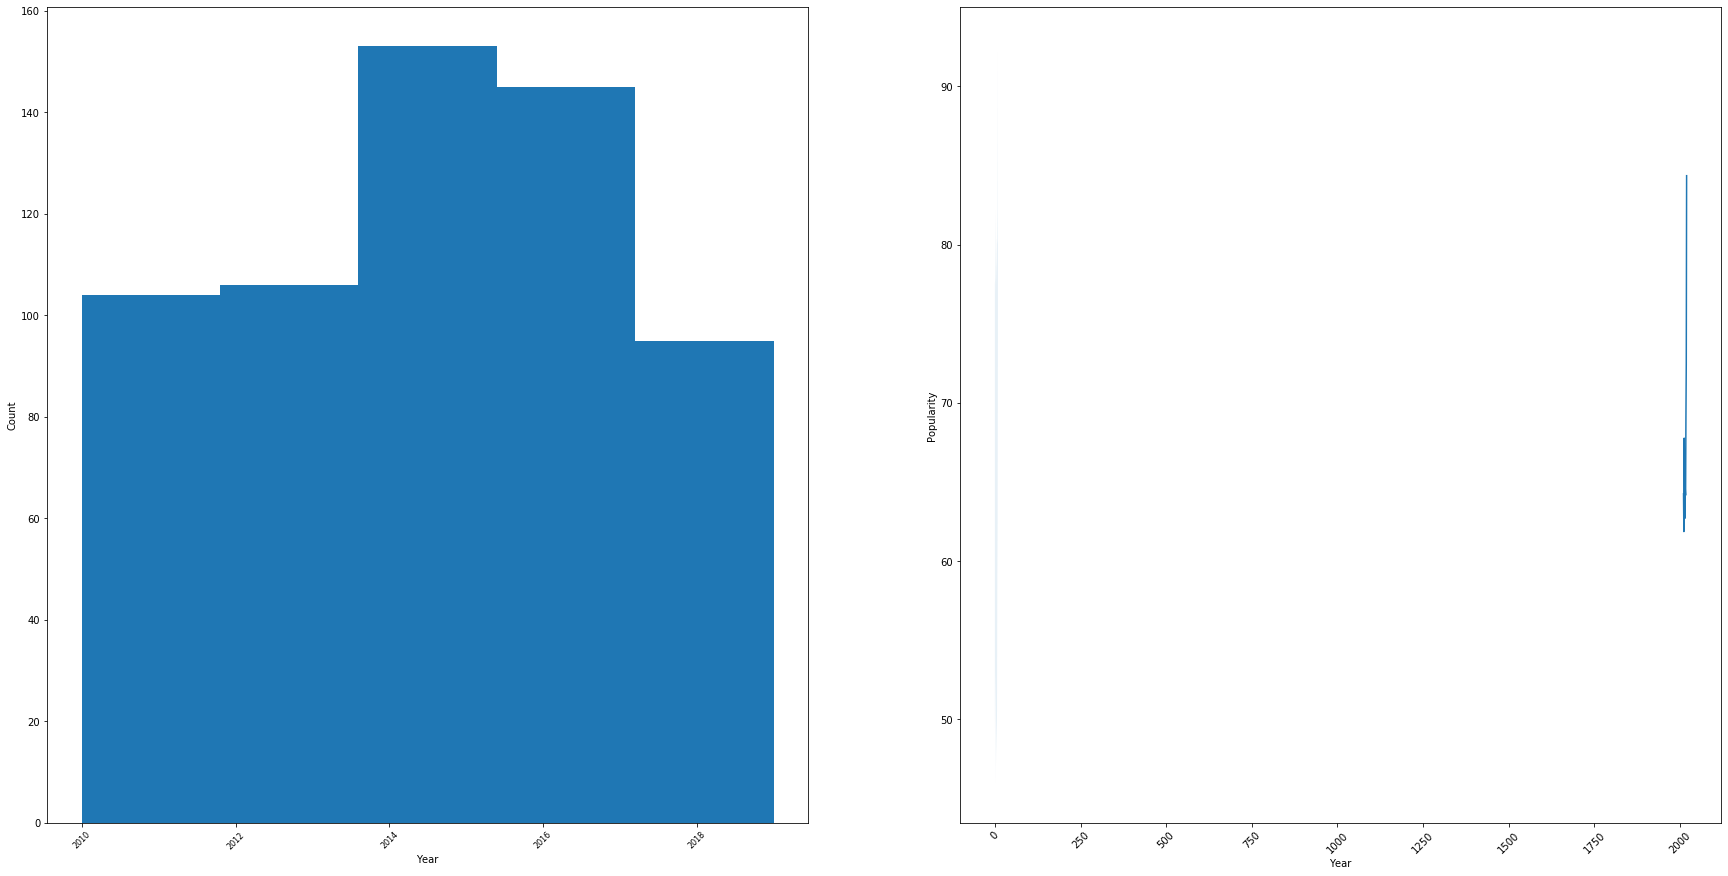

In [22]:
plotFeats(df, 'Year')

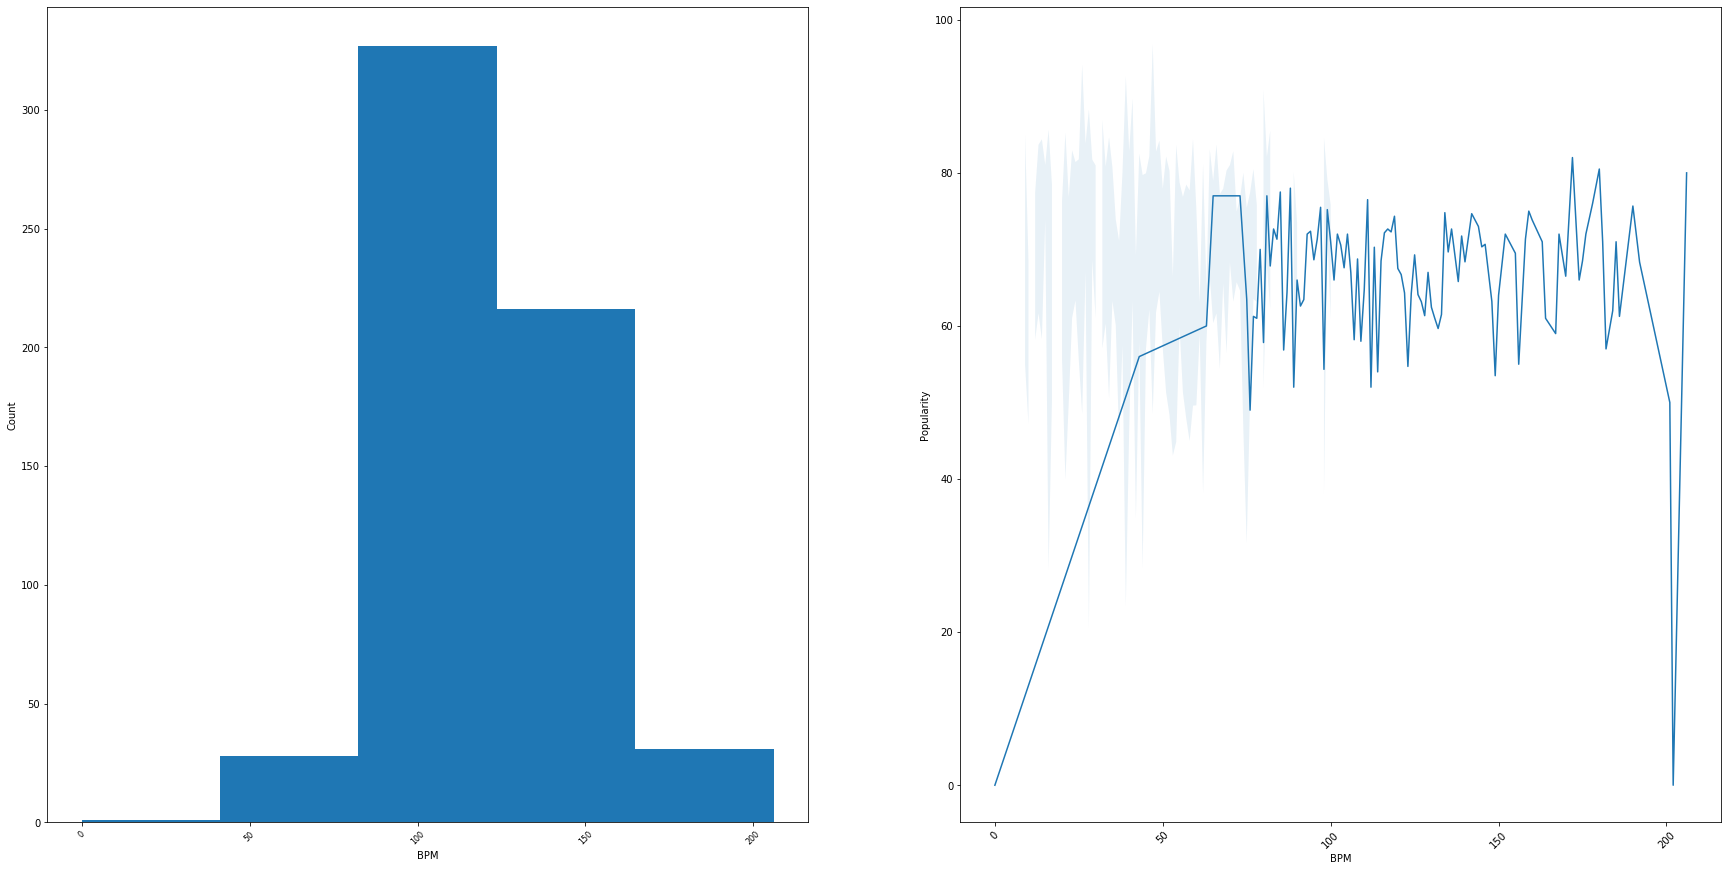

In [23]:
plotFeats(df, 'BPM')

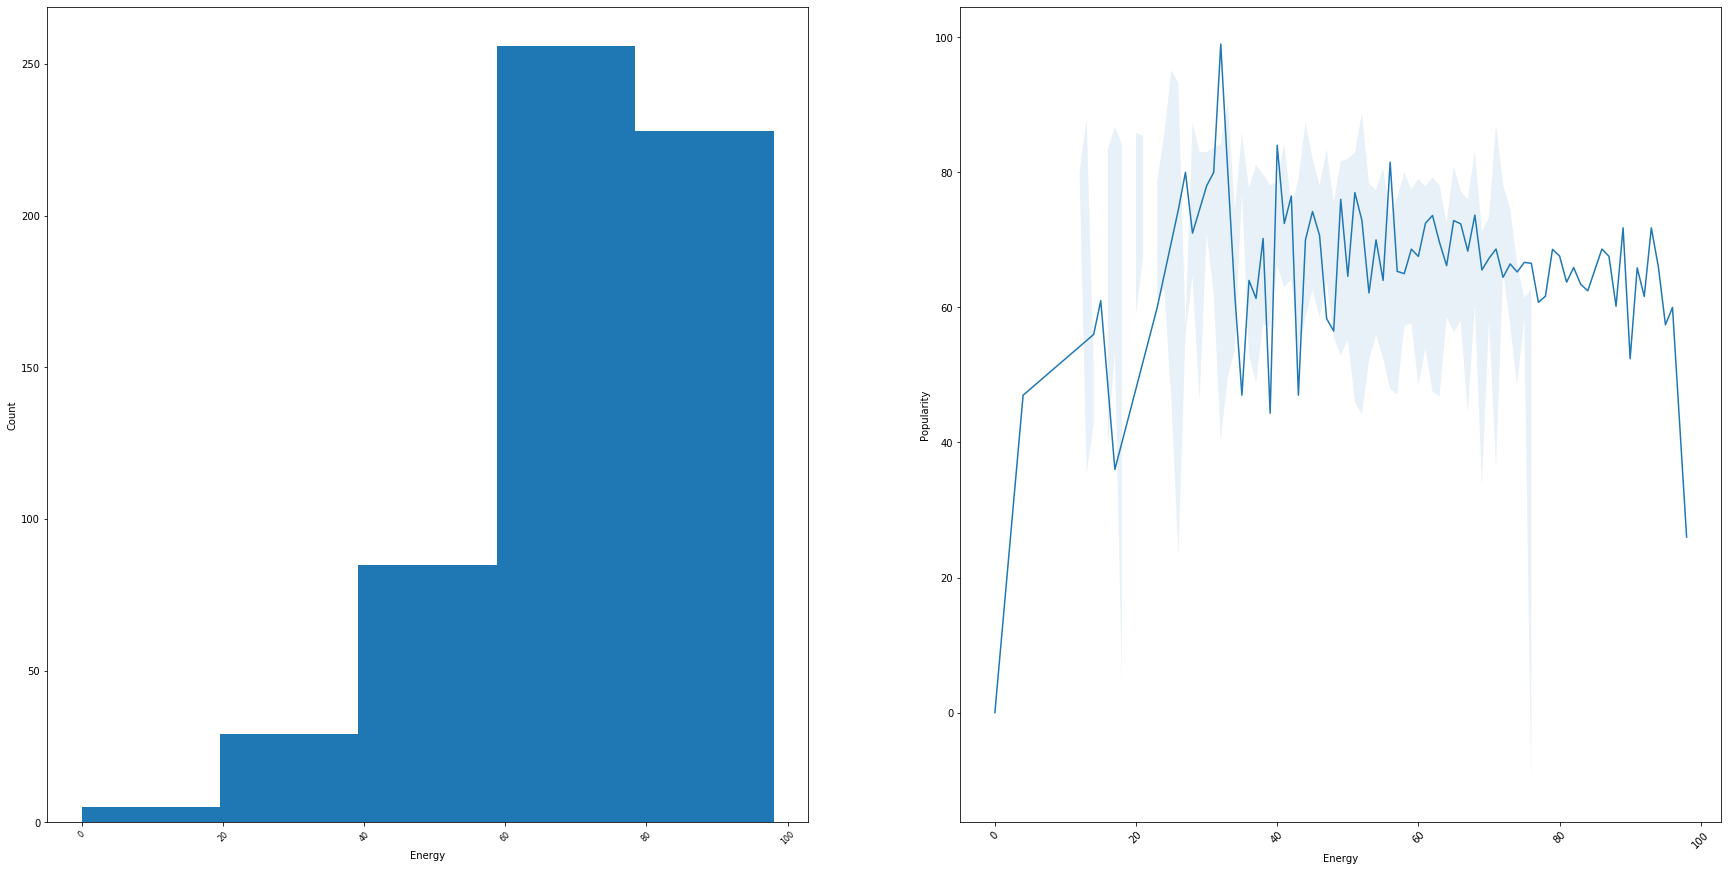

In [24]:
plotFeats(df, 'Energy')

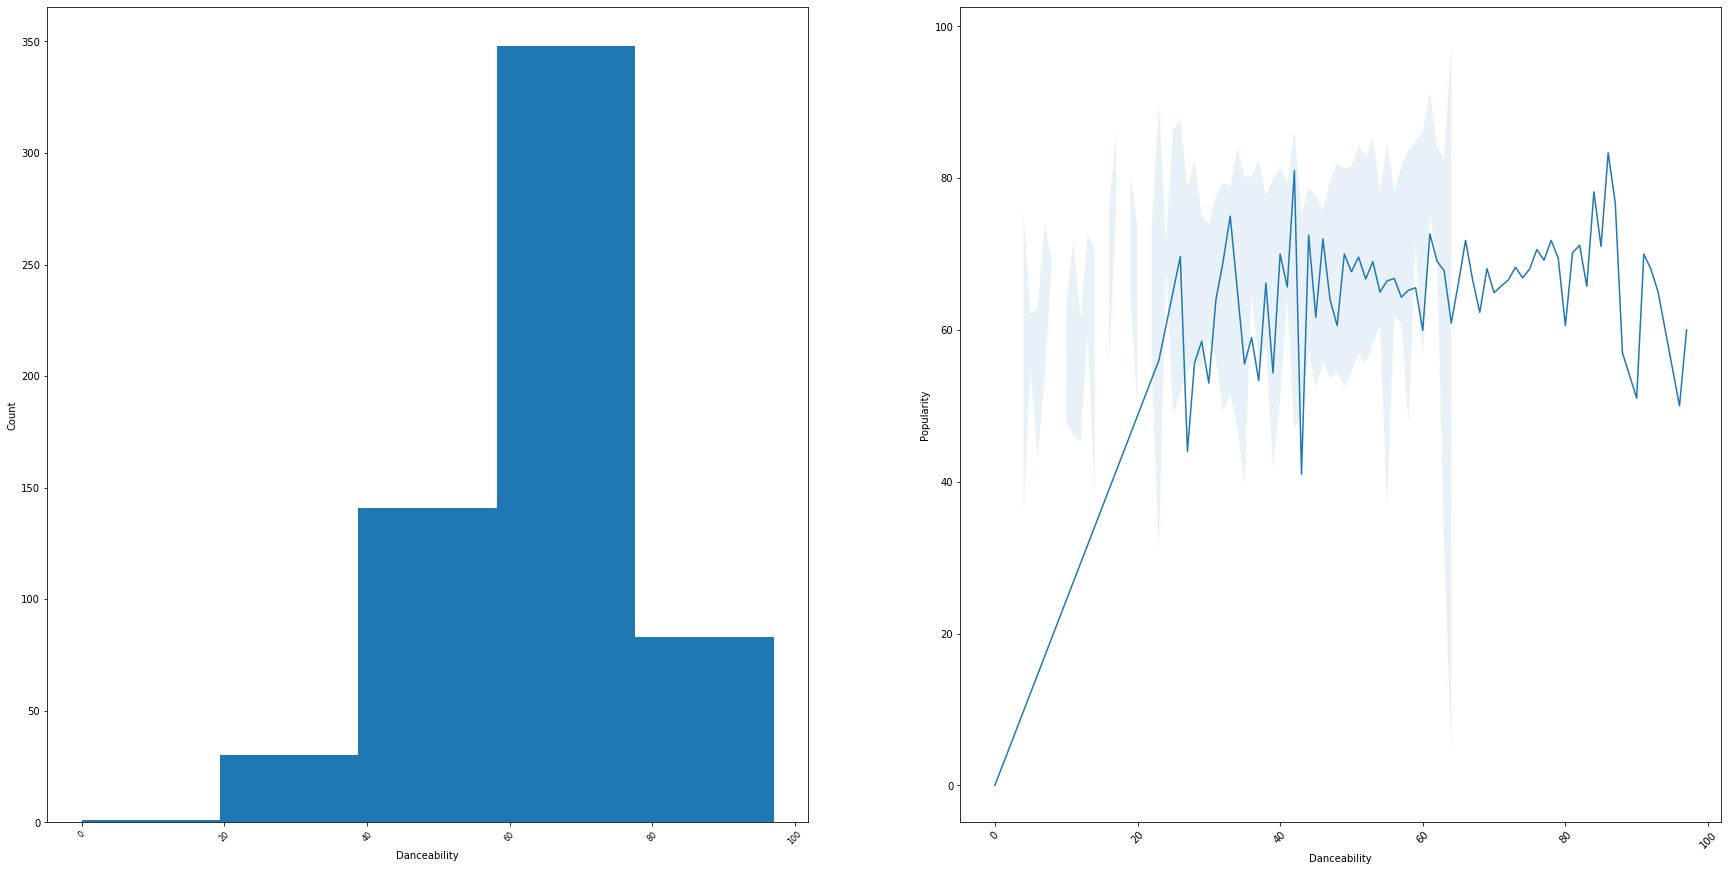

In [25]:
plotFeats(df, 'Danceability')

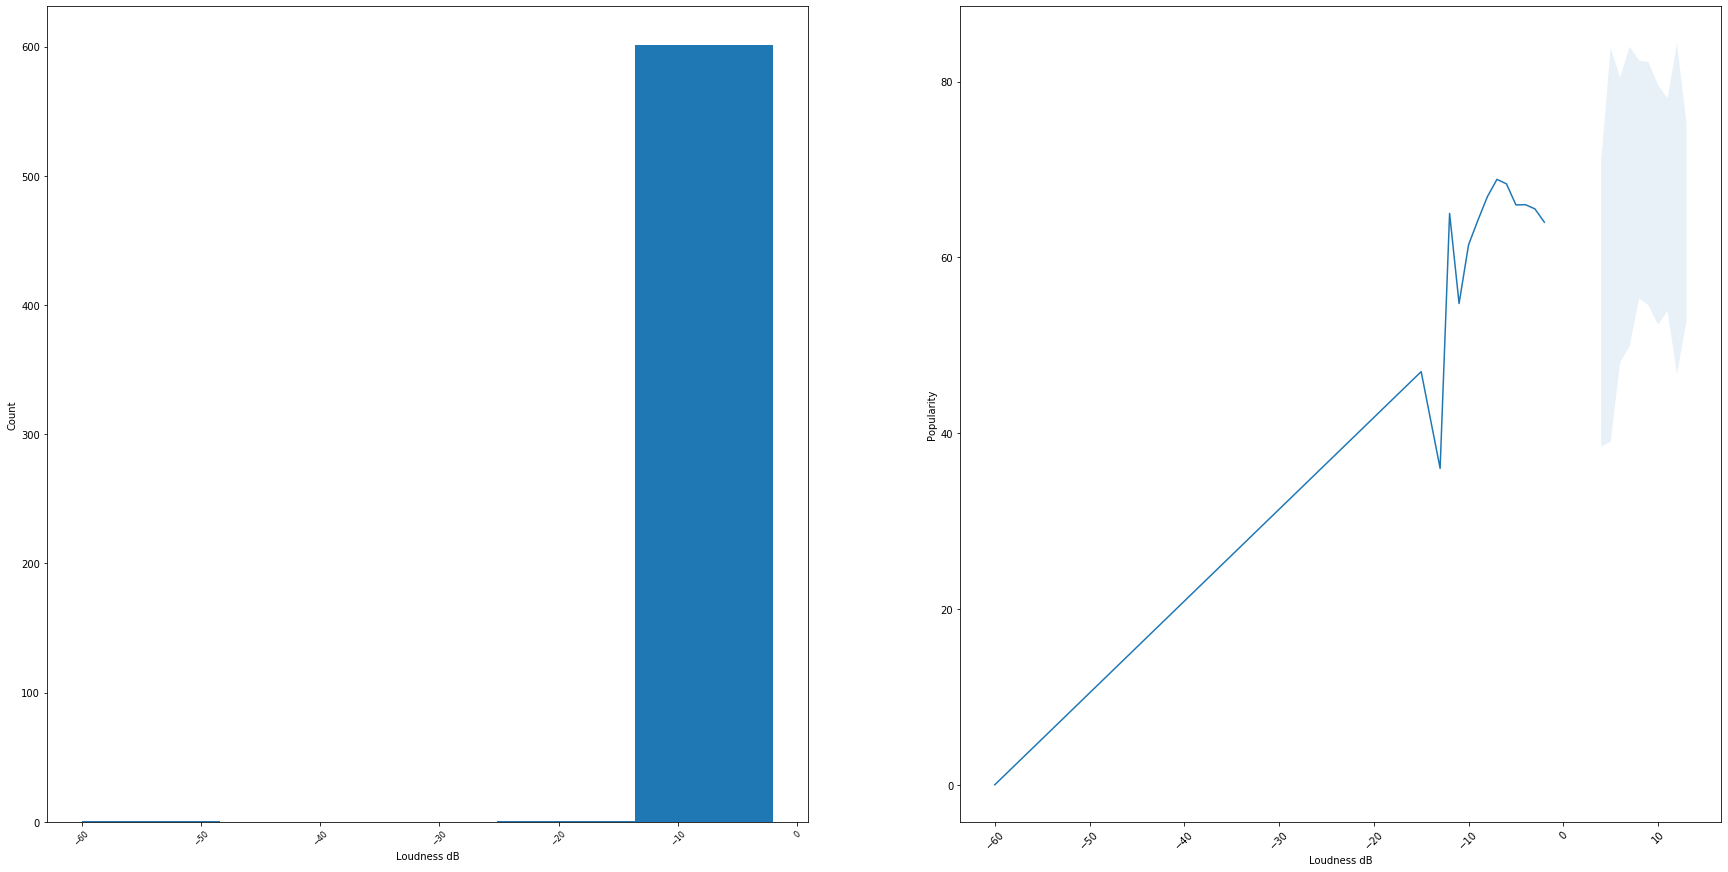

In [26]:
plotFeats(df, 'Loudness dB')

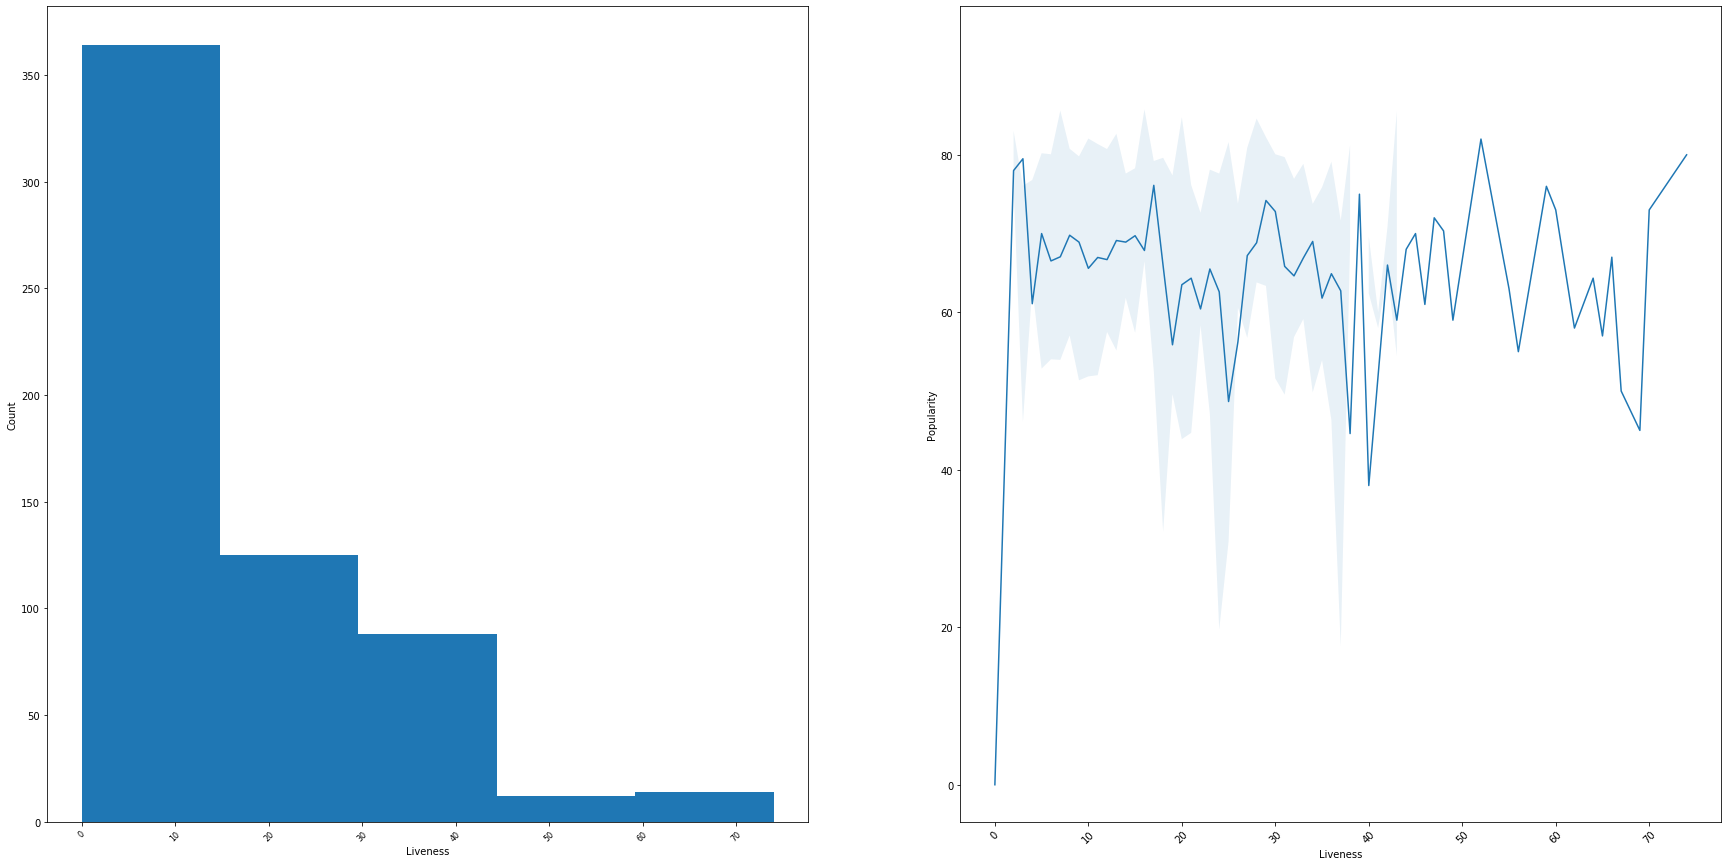

In [27]:
plotFeats(df, 'Liveness')

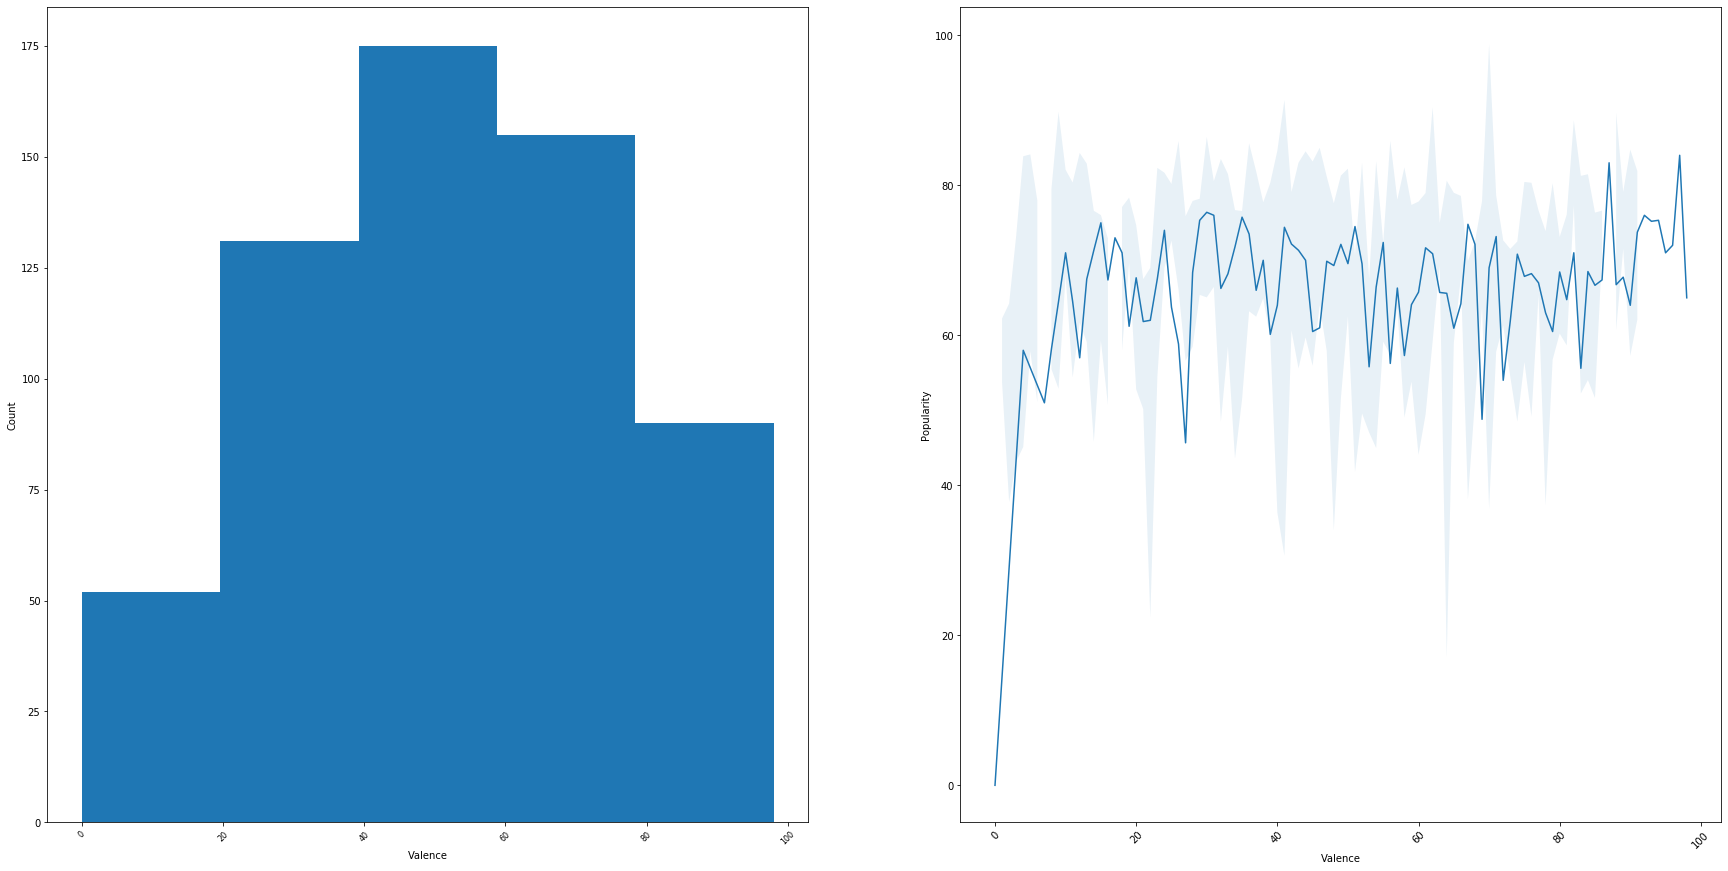

In [28]:
plotFeats(df, 'Valence')

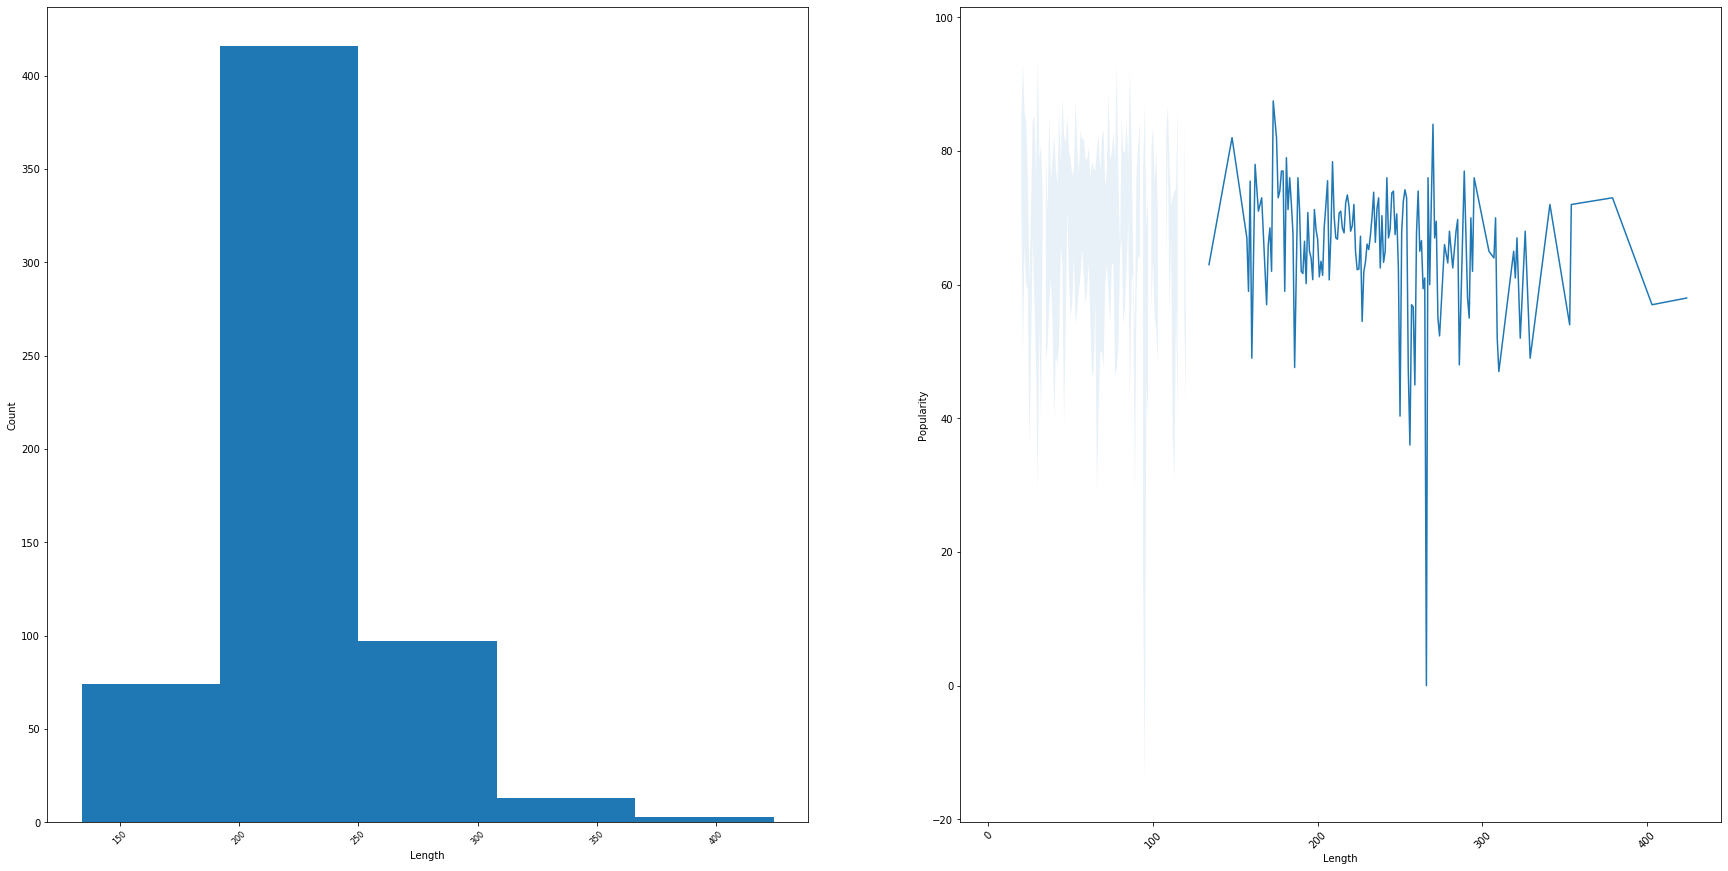

In [29]:
plotFeats(df, 'Length')

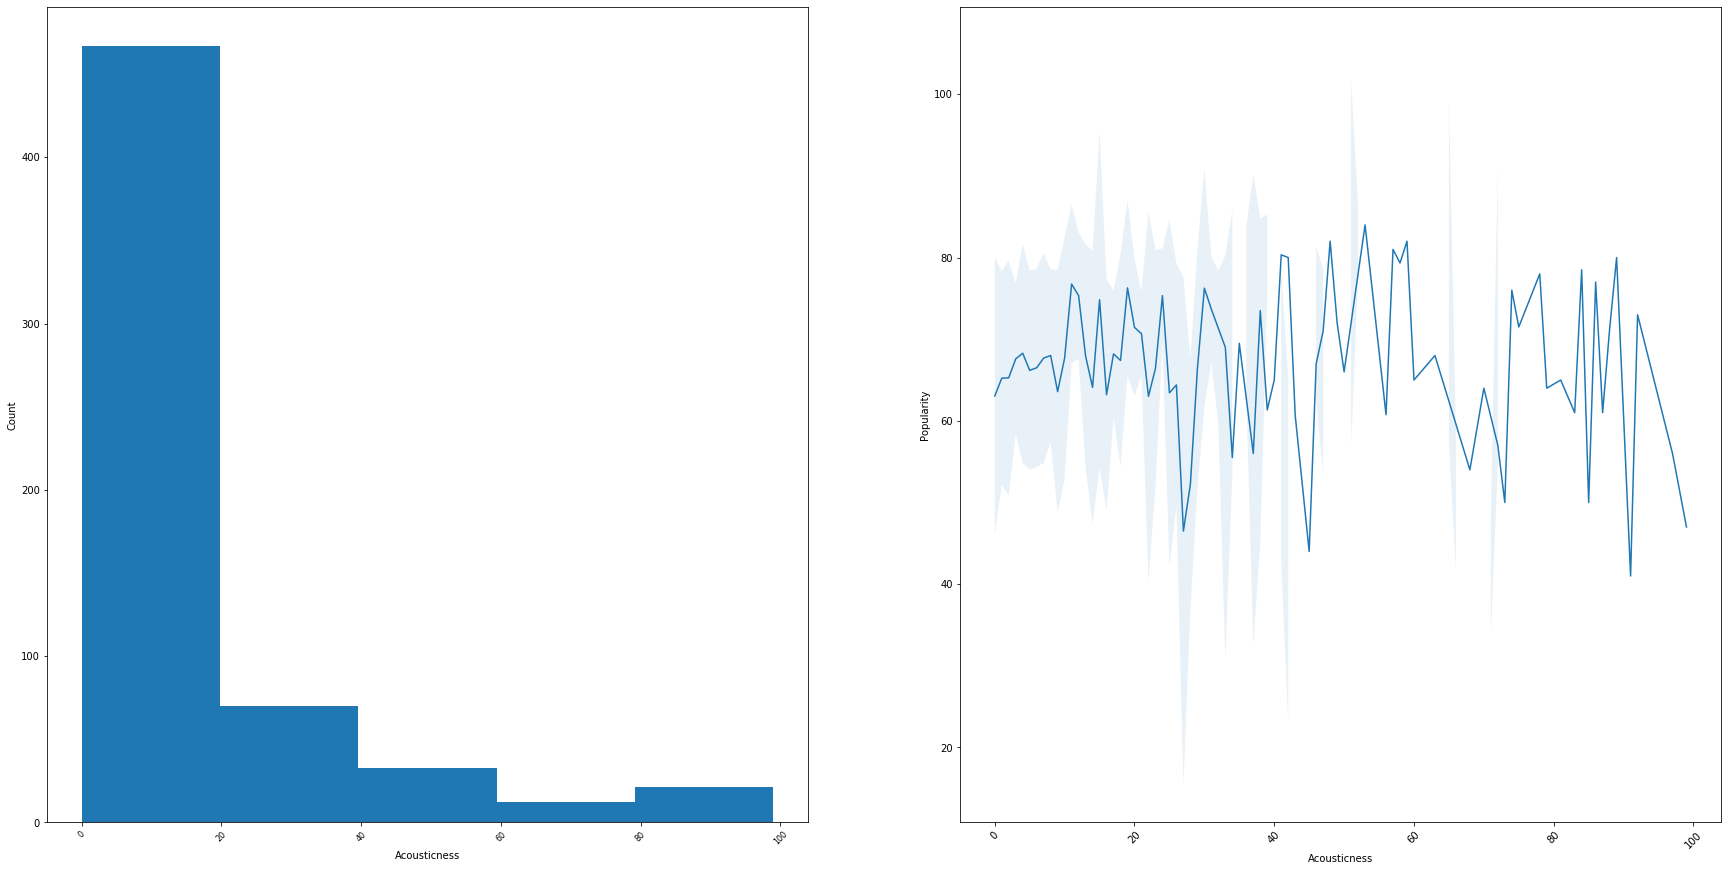

In [30]:
plotFeats(df, 'Acousticness')

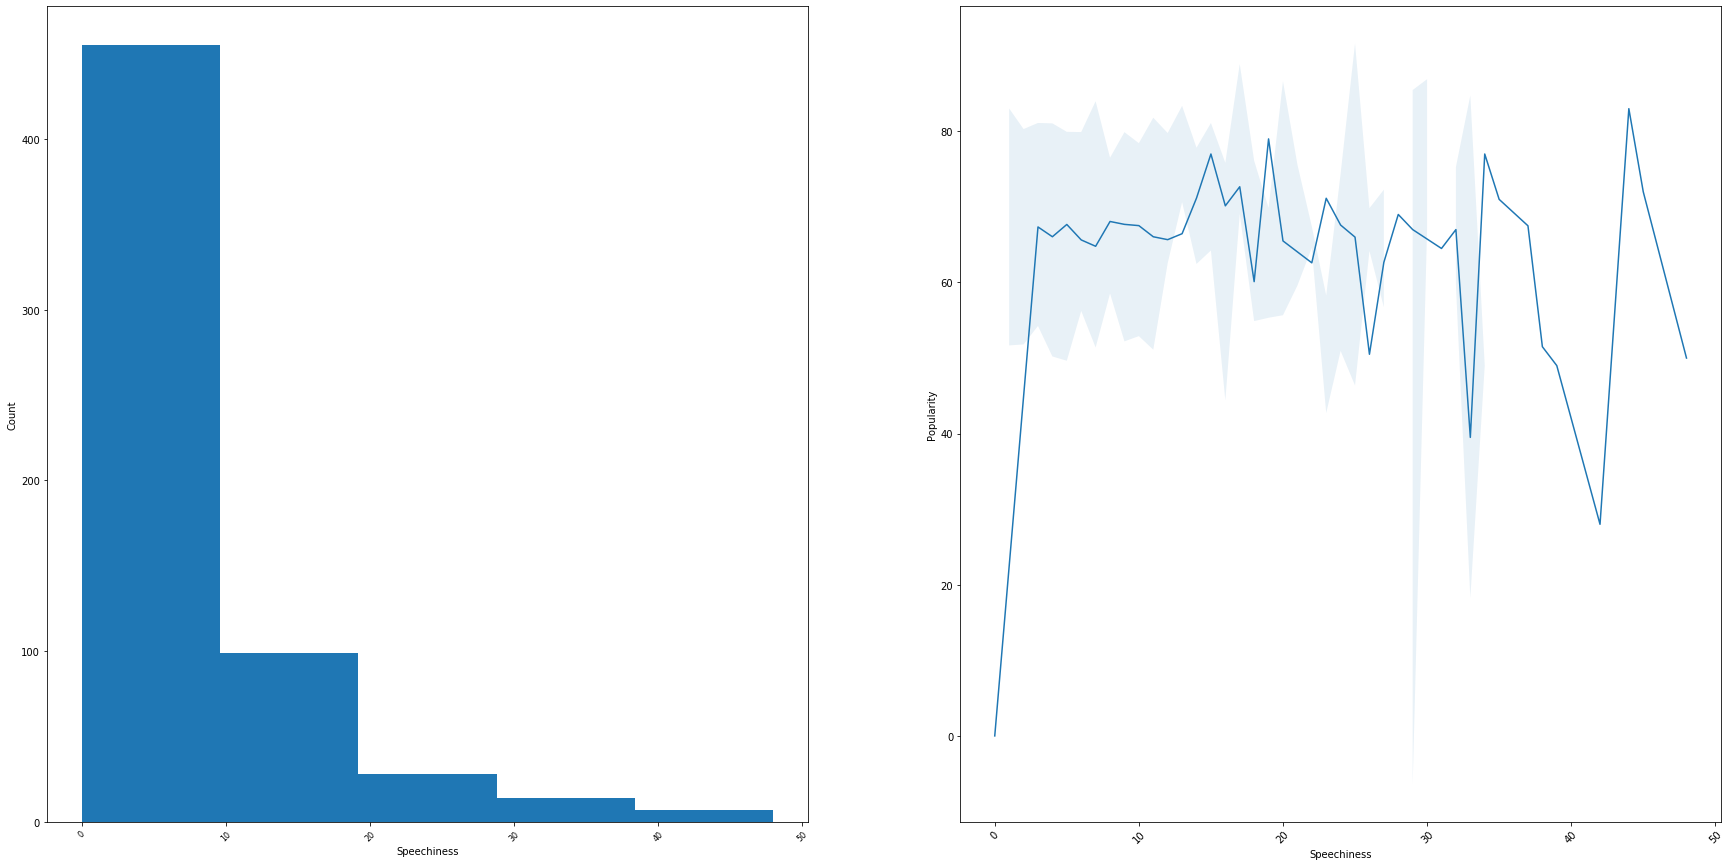

In [31]:
plotFeats(df, 'Speechiness')

###### Our plotted models reveal an interesting insight from our data. 

<i>It turns out that many features have a very poor relation with popularity. Because the relationship is poor, this means that these particular features are not correlated with popularity. In other words, these features, which we'll explain below, do not correlate with the popularity of that particular song. There were a few exceptions though... </i>

<br>
Starting from the beginning, let's look at the 3 best features:

<h4>"Artist"</h4>

The Artist plot shows a visible sine wave across the popularity of each song. 

<b>"Does this mean a particular artist has higher chances of releasing a top hit just from being who they are?"</b>

The answer is a bit more complicated than a simple 'yes' or 'no'. We will need to compare artists against other features to gain more insight... (More visualization on Tableau). But in short, yes, this could be an indicator. 

<br>
Moving on, second on our list is:
<h4>"Genre"</h4> 
As it has an almost linear correlation with popularity. What does this mean?

Depending on the genre, the likelihood of hitting the top of the charts increases. This doesn't assume that this dataset could simply have more songs of that particular genre, but if believed to be balanced, genre has a strong correlation to popularity. 

<br>
The last one that is worth mentioning:
<h4>Loudness db</h4>

There seems to be, again, a linear correlation to loudness against popularity. Here's an insider insight: songs that are professionally and strongly mastered are likely to be heard more times. Loudness here means how clear you can hear that song in a set volume as you play the entire playlist. Each song competes for attention and the louder the sound is without distorting, the better each element will sound, which in turn will increase the likelihood of the song popularity. 

To summarize, loudness increases the popularity based on the assumption that the clearer and more potent all the elements in the song are heard, the better the melody will be perceived and therefore liked, resulting in increased popularity. 

<br>
All other features seemed to be spreaded throughout the spectrum of popularity, which shows us the correlation is weak. For example, 'length' is insiginificant when prediciting popularity because a short or a long length gives no insight on how popular that song is. 

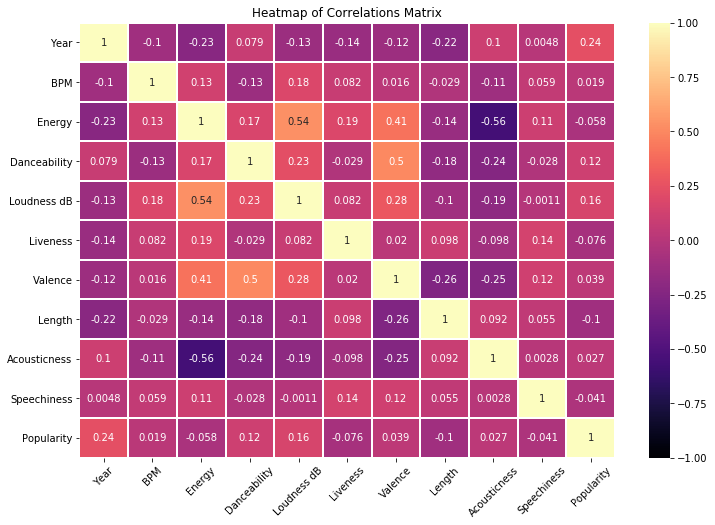

In [32]:
# Visualizing all these features in a heatmap.

plt.figure(figsize = (12, 8))
corr = df.corr()
sns.heatmap(corr, 
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values,
           cmap = "magma", vmin = - 1, vmax = 1, annot = True, linewidths = 1)
plt.title('Heatmap of Correlations Matrix')
plt.xticks(rotation=45)
plt.show()

Interestingly enough, the heatmap not only shows the correlation with popularity, but with all other features against one another. Acousticness vs. Energy seems to have a reasonable correlation.

Note: Artist and Genre aren't shown in the heatmap because they aren't ordinal, but we saw on the boxplots above that they're the strongest correlators to popularity.

# Now, we ask the question:
How likely is a song to hit top popularity based on its artist, genre and loudness?
<br>
<br>
Where:<br>
"Artist, Genre and Loudness" were determined to be the strongest correlators to popularity. 

<br>
"Top Popularity" is a popularity score within the 75% upper percentile.
<br>
<br>
"Likelihood" assesses the chances a song has of meeting the above criteria based on those attributes. 

Meaning, does song "One" from artist A1, genre B1 and loudness C1 have a higher change of hitting 75% or more in popularity than song "One" from artist A2, genre B2 and loudness C2?

#### Establishing a baseline

Based on our data, we will use classification methods like Linear SVC (Support Vector Classification) or Naive Bayes to predict the model. Improving and fine tuning the model will come later on.

In [33]:
def EncodeData(df):
    for col in df.columns:
        if df[col].dtype.name == 'category':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
    return df

In [34]:
baselineDF = df.copy()
baselineDF = EncodeData(baselineDF)

In [35]:
featsBaseline = baselineDF[['Index', 'Title', 'Artist', 'Genre', 'Year', 
                            'BPM', 'Energy', 'Danceability', 'Loudness dB', 
                            'Liveness', 'Valence', 'Length', 'Acousticness', 
                            'Speechiness', 'Popularity']]
targsBaseline = baselineDF[['Popularity']]

In [36]:
lr = LinearRegression()
baseLrMse = cross_val_score(lr, featsBaseline, targsBaseline, scoring = 'neg_mean_squared_error')
baseLrMse = -1*baseLrMse.mean()
print('Baseline MSE Score: ', baseLrMse)

Baseline MSE Score:  1.1363964962922254e-27


#### Hypothesizing solutions

Choosing some 3 models that may improve results over the baseline model.

# 3. Develop
The model.


Now we'll create features, tune models and train/valide them until we reach an efficacy goal.

#### Feature Engineering
Using OHE (one-hot-encoding) to transform categorical features into data types we can manipulate and make calculations with. 

In [37]:
# Dropping 'index' because it is useless for our OHE algorithms. 
df = df.drop(['Index'], axis=1)

In [38]:
# Check to see that the column was dropped with: 
df.info()
#or
#df.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 1 to 603
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Title         603 non-null    category
 1   Artist        603 non-null    category
 2   Genre         603 non-null    category
 3   Year          603 non-null    int64   
 4   BPM           603 non-null    int64   
 5   Energy        603 non-null    int64   
 6   Danceability  603 non-null    int64   
 7   Loudness dB   603 non-null    int64   
 8   Liveness      603 non-null    int64   
 9   Valence       603 non-null    int64   
 10  Length        603 non-null    int64   
 11  Acousticness  603 non-null    int64   
 12  Speechiness   603 non-null    int64   
 13  Popularity    603 non-null    int64   
dtypes: category(3), int64(11)
memory usage: 113.4 KB


In [39]:
categoryDF = df[['Title', 'Artist', 'Genre']]
categoryDF = pd.get_dummies(categoryDF, drop_first=True)

In [40]:
# Normalizing values.

normalDF = df[['Year', 'BPM', 'Energy', 'Danceability', 'Loudness dB', 'Liveness', 
               'Valence', 'Length', 'Acousticness', 'Speechiness']]
cols = normalDF.columns
normalDF = MinMaxScaler().fit_transform(normalDF)
normalDF = pd.DataFrame(normalDF, columns = cols)

In [41]:
# Concatenating both into one dataframe.

featsDF = pd.concat([categoryDF.reset_index(drop=True), normalDF], axis=1)
targsDF = df[['Popularity']]

In [42]:
featsDF.shape

(603, 825)

In [43]:
del categoryDF, normalDF

#### Creating Models

In [44]:
# Out of the models we brainstormed earlier, we'll create and fine tune them now. 
# Starting with a kFold - Cross Validation, where k = 5.

def evalModel(model):
    negMse = cross_val_score(model, featsDF, targsDF.values.ravel(), 
                             scoring = 'neg_mean_squared_error')
    mse = -1 * negMse
    stdMse = round(mse.std(), 2)
    meanMse = round(mse.mean(), 2)
    print('\nModel\n', model)
    print('    Standard Deviation of Cross Validation MSEs:\n    ', stdMse)
    print('    Mean 5-Fold Cross Validation MSE: \n    ', meanMse)
    return meanMse

#### Testing Models

In [45]:
models = []
meanMse = {}

# Linear Regression
lr = LinearRegression()

# Decision Tree Regressor
dtr = DecisionTreeRegressor(max_depth=15)

# Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=150, n_jobs=-1, max_depth=30, min_samples_split=60, 
                            max_features='sqrt')
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(max_depth = 3, n_estimators=150, learning_rate = 0.1, 
                                 n_iter_no_change=10)
# Stochastic Gradient Descent
sgd = SGDRegressor(max_iter=1000, learning_rate='optimal')

# Extreme Gradient Boosting
xgb = xgboost.XGBRegressor(max_depth=5, n_estimators=150, learning_rate=0.1, n_jobs=-1)

models.extend([lr, dtr, rfr, gbc, sgd, xgb])
print('Cross Validation of Models Initiated...\n')

for model in models:
    mseIter = evalModel(model)
    meanMse.update({model:mseIter})
    
bestModel = min(meanMse, key=meanMse.get)

print('\n\nThe model with the lowest average MSE to use for predictions is:\n')
print(bestModel)

Cross Validation of Models Initiated...


Model
 LinearRegression()
    Standard Deviation of Cross Validation MSEs:
     2.8366404409856864e+27
    Mean 5-Fold Cross Validation MSE: 
     3.0190280929264666e+27

Model
 DecisionTreeRegressor(max_depth=15)
    Standard Deviation of Cross Validation MSEs:
     63.18
    Mean 5-Fold Cross Validation MSE: 
     250.95

Model
 RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=60,
                      n_estimators=150, n_jobs=-1)
    Standard Deviation of Cross Validation MSEs:
     41.35
    Mean 5-Fold Cross Validation MSE: 
     194.47

Model
 GradientBoostingClassifier(n_estimators=150, n_iter_no_change=10)
    Standard Deviation of Cross Validation MSEs:
     nan
    Mean 5-Fold Cross Validation MSE: 
     nan


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 423, in fit
    train_test_split(X, y, sample_weight,
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py", line 2152, in train_test_split
    train, test = next(cv.split(X=arrays


Model
 SGDRegressor(learning_rate='optimal')
    Standard Deviation of Cross Validation MSEs:
     7.142664121049749e+19
    Mean 5-Fold Cross Validation MSE: 
     5.3458841908248986e+19

Model
 XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
    Standard Deviation of Cross Validation MSEs:
     nan
    Mean 5-Fold Cross Validation MSE: 
     nan


The model with the lowest average MSE to use for predictions is:

RandomForest

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 501, in fit
    train_dmatrix = DMatrix(data=X, label=y, weight=sample_weight,
  File "/Applications/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 558, in __init__
    self.feature_names = feature_names
  File "/Applications/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 1011, in feature_names
    raise ValueError('feature_names must be string, and may not contain [, ] or <')
ValueError: feature_names must be string, and may not contain [, ]

In [47]:
# Adding the meanMse dictionary into a DataFrame.

modelsDF = pd.DataFrame.from_dict(data = meanMse, orient='index', columns=['MSE-Score'])
modelsDF.index = ['LR', 'DTR', 'RF', 'GBC', 'SDG', 'XGB']
modelsDF

,MSE-Score
LR,3.019028e+27
DTR,2.509500e+02
RF,1.944700e+02
GBC,NaN
SDG,5.345884e+19
XGB,NaN


#### Selecting the best model

Based on the results above, Random Forest performed better than the others. We will use RF to fine tune it and test it. 

In [48]:
trainX, testX, trainY, testY = train_test_split(featsDF, targsDF, random_state=36, test_size=0.2)

In [49]:
# Initiating array to store results
results = []

# Initiating a watchlist to keep track of performance
evalSet = [(trainX, trainY), (testX, testY)]

# Checking hyperparameters.
print(inspect.signature(RandomForestRegressor))

(n_estimators=100, *, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)


In [53]:
results = []

for n_estimators in [10, 100, 150, 250, 500, 750, 1000, 1500, 2000, 3000, 5000, 10000]:
    clf = RandomForestRegressor(n_estimators = n_estimators, n_jobs = -1, max_depth = 70,
                               min_samples_split = 60, max_features = 'sqrt')
    clf.fit(trainX, trainY)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_error': metrics.mean_squared_error(trainY, clf.predict(trainX)),
            'test_error': metrics.mean_squared_error(testY, clf.predict(testX))
        })
    
# Showing results
nEstimatorsLr = pd.DataFrame(results).set_index('n_estimators').sort_index()
nEstimatorsLr

<ipython-input-53-38e22ce90d64>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-53-38e22ce90d64>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-53-38e22ce90d64>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-53-38e22ce90d64>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-53-38e22ce90d64>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

,train_error,test_error
n_estimators,,
10,101.038807,205.988365
100,97.209132,197.175462
150,101.340737,198.283577
250,97.814210,196.462616
500,97.116257,195.465240
750,96.157255,194.615432
1000,97.716343,195.333866
1500,97.056726,195.637052
2000,98.452703,196.023761


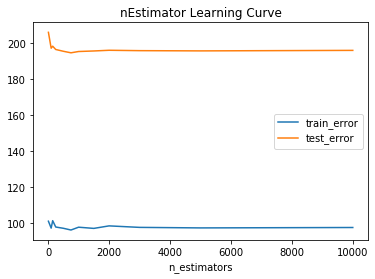

In [54]:
# Let's plot those results above.

nEstimatorsLr.plot(title='nEstimator Learning Curve')

The results show that the model remains constant throughout with a slight improvement at 750, so that will be our nEstimator hyperparameter value.

In [55]:
results = []

for max_depth in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 500]:
    clf = RandomForestRegressor(max_depth = max_depth, max_features='sqrt',
                                n_estimators = 750, n_jobs = -1)
    clf.fit(trainX, trainY)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': metrics.mean_squared_error(trainY, clf.predict(trainX)),
            'test_error': metrics.mean_squared_error(testY, clf.predict(testX))
        })
    
# Displaying the results.
maxDepthLr = pd.DataFrame(results).set_index('max_depth').sort_index()
maxDepthLr

<ipython-input-55-f9569199b9d8>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-55-f9569199b9d8>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-55-f9569199b9d8>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-55-f9569199b9d8>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-55-f9569199b9d8>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

,train_error,test_error
max_depth,,
10,131.348722,204.555082
20,77.081592,193.747487
30,45.773412,192.986240
40,32.343021,189.623330
50,27.422909,188.306034
60,25.304026,190.131066
70,24.943544,191.359649
80,24.613019,189.960646
90,24.315863,188.277415


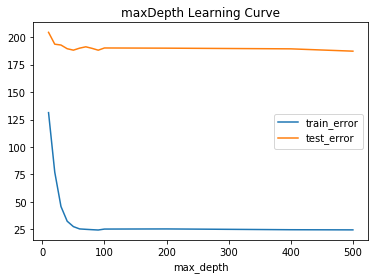

In [56]:
# Visualizing the maxDepth learning curve.
maxDepthLr.plot(title='maxDepth Learning Curve')

Peak performance stops improving at 90 for both train and test, so that will be our maxDepth hyperparameter value.

In [57]:
results = []

for min_samples_split in [2, 4, 8, 20, 40, 60, 80, 100, 200, 500]:
    clf = RandomForestRegressor(max_depth=90, max_features='sqrt', 
                                n_estimators=750, n_jobs=-1)
    clf.fit(trainX, trainY)
    results.append(
        {
            'min_samples_split': min_samples_split,
            'train_error': metrics.mean_squared_error(trainY, clf.predict(trainX)),
            'test_error': metrics.mean_squared_error(testY, clf.predict(testX))
        })
    
    
    
# Displaying Results  
minSamples = pd.DataFrame(results).set_index('min_samples_split').sort_index()
minSamples

<ipython-input-57-1b53f6c7fc8d>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-57-1b53f6c7fc8d>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-57-1b53f6c7fc8d>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-57-1b53f6c7fc8d>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX, trainY)
<ipython-input-57-1b53f6c7fc8d>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

,train_error,test_error
min_samples_split,,
2,24.536142,189.688535
4,25.241143,186.420830
8,24.805499,189.285499
20,25.103136,189.067890
40,24.570201,190.081747
60,24.970962,190.555787
80,24.370942,188.104016
100,24.740506,189.440481
200,25.229321,188.703153


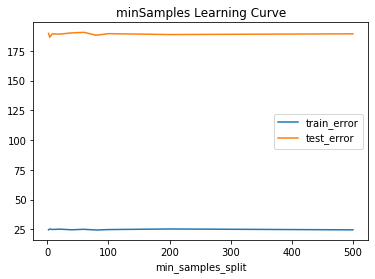

In [59]:
# Visualizing the minSamples learning curve. 
minSamples.plot(title='minSamples Learning Curve')

At 4, test scores good but train doesn't. At 80, both train and test score good but not enough to justify the extra computaitonal burden. Therefore, 4 is the value for min_samples_split hyperparameter.

In [136]:
# Saving the best hyperparameter setting.
bestModel = RandomForestRegressor(max_depth=70, n_estimators=500, min_samples_split=4, 
                                  criterion='mse', n_jobs=-1, 
                                  verbose=2, min_impurity_decrease = 1.0)

In [63]:
# Fitting the training set and applying early stopping.
bestModel.fit(trainX, trainY)

<ipython-input-63-da95768bef24>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bestModel.fit(trainX, trainY)


RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=60,
                      n_estimators=150, n_jobs=-1)

In [138]:
# Saving the best hyperparameter setting with n_estimators from early stopping.
bestModel = RandomForestRegressor(max_depth=70, max_features='sqrt', min_samples_split=20, 
                                  n_estimators=300, n_jobs=-1)

In [139]:
evalModel(bestModel)


Model
 RandomForestRegressor(max_depth=70, max_features='sqrt', min_samples_split=20,
                      n_estimators=300, n_jobs=-1)
    Standard Deviation of Cross Validation MSEs:
     41.08
    Mean 5-Fold Cross Validation MSE: 
     193.53


193.53

#### Conclusion

Fine tuning improved the model a little bit (from 195.xx to 194.xx), so we'll use these tuned hyperparameters to deploy the solution.

# 4. Deploy
The solution.

Automating the pipeline. Writting a function to train the whole training set and saves to disk.

In [215]:
def trainedCleanModelDF (df, df50):
    
    # Loading csv files
    featsDF = pd.read_csv(df)
    targsDF = pd.read_csv(df50)
    
    # Cleaning feature and target dataframes per analysis above
    df = pd.concat([featsDF, targsDF], axis=0)
    catsDF = df[['Title', 'Artist', 'Genre']]
    catsDF = pd.get_dummies(catsDF, drop_first=True)
    featsDF = pd.concat([catsDF, df[['Year', 'BPM', 'Energy', 'Danceability', 'Loudness dB', 
                                     'Liveness', 'Valence', 'Length', 'Acousticness', 
                                     'Speechiness']]], axis=1)
    targsDF = df[['Popularity']]
    del catsDF #, df
    
    # Implement best model discovered per analysis above
    model = RandomForestRegressor(max_depth=70, max_features='sqrt', min_samples_split=20,
                      n_estimators=300, n_jobs=-1)
    model.fit(featsDF, targsDF)
    
    # Save model to disk
    model_file = 'model'
    pickle.dump(model, open(model_file, 'wb'))
    
    # Informs user that process is complete
    print('Data prepraration and model creation complete.')

In [216]:
# Script that prepares data, predicts popularity, and exports results.

class popularityPredictionModel():
    
    # Read the 'model' file which was saved.
    def __init__(self, model_file):
        self.rfr = pickle.load(open(model_file, 'rb'))
    
    # Takes/prepares data, makes predictions from trained model, and exports results to csv file.
    def exportPredictions(self, data_file):

        # Load csv file.
        df_pred_features = pd.read_csv(data_file)
    
        # Saves Popularity column for output file.
        df_pred_popular = pd.DataFrame(df_pred_features['Popularity'])
        
        # Prepares data to be fed into the model
        df_pred_categories = df_pred_features[['Title', 'Artist', 'Genre', 'Year', 
                                               'BPM', 'Energy', 'Danceability', 
                                               'Loudness dB', 'Liveness', 'Valence', 
                                               'Length', 'Acousticness', 'Speechiness']]
        df_pred_categories = pd.get_dummies(df_pred_categories, drop_first=True)
        df_pred_features = pd.concat([df_pred_categories, df_pred_features], axis=1)
        del df_pred_categories
    
        # Loads model from disk, predicts popularity, and exports results to .csv file
        df_pred = pd.DataFrame(self.rfr.predict(df_pred_features))
        df_pred.columns = ['Popularity']
        df_pred = pd.concat([df_pred_popular,df_pred], axis=1)
        df_pred.to_csv('predicted_popularity.csv')
        del df_pred_popular
        
        # Informs user that process is complete
        print('Predictions exported to .csv file.')
    
    # Plot feature importance of model and save figure to .jpg file
    def exportFeatureImportance(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        RandonForestRegressor.plot_importance(self.rfr, height=0.6, ax=ax)
        fig.savefig('feature_importance.jpg')
    
        # Informs user that process is complete
        print('Feature importances exported to .jpg file.')

In [222]:
trainedCleanModelDF('top10s.csv', "top50.csv")

In [223]:
model = popularityPredictionModel('model')

In [226]:
model.exportPredictions('../Spotify/test_spotify.csv')

In [228]:
model.exportFeatureImportance()

In [ ]:
# Work in progress...